# Self-Driving Car Engineer Nanodegree

## Computer Vision

## Project: Vehicle Detection and Tracking

### Starter code

#### Import of libraries

In [29]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label

#### Declaration of global variables

In [30]:
car_complete_data_path = "complete-dataset/vehicles/*.png"
noncar_complete_data_path = "complete-dataset/non-vehicles/*.png"
car_partial_data_path = "partial-dataset/vehicles/*.jpeg"
noncar_partial_data_path = "partial-dataset/non-vehicles/*.jpeg"
test_images_path = "test_images/*.jpg"
output_images_path = "output_images/"
challenge_images_path = "challenge-images/*.jpg"

#### Extract images using glob

In [31]:
def extract_images(imgs_path, return_path_only=True):
    images = []
    images_path = glob.glob(imgs_path)
    if (return_path_only == False):
        for image_path in images_path:
            image = cv2.imread(image_path)
            images.append(image)
    images = np.array(images)
    return_dict = {
        "imgs_path": images_path,
        "imgs": images
    }
    return return_dict
# extract = extract_images(car_partial_data_path, return_path_only=False)
# print(len(extract["imgs_path"]))
# print(len(extract["imgs"]))
# plt.imshow(extract[imgs][0])
# plt.show()

#### Dataset exploration

In [32]:
def explore_data(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    test_img = cv2.imread(car_list[0])
    shape = test_img.shape
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_img.dtype
    # Return data_dict
    return data_dict
# cars = extract_images(car_partial_data_path)["imgs_path"]
# noncars = extract_images(noncar_partial_data_path)["imgs_path"]
# exploration = explore_data(cars, noncars)
# print(exploration)

###  Goal 1 - Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images

In [33]:
def hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, do_transform_sqrt=True, visualization=False, feature_vec=True):
    if visualization == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=visualization, feature_vector=feature_vec)
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=do_transform_sqrt, visualise=visualization, feature_vector=feature_vec)
        hog_image = None
    return features, hog_image
# image = extract_images(car_partial_data_path, return_path_only=False)["imgs"][0]
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# hog_features, hog_image = hog_features(gray, orient=9, pix_per_cell=8, cell_per_block=2, visualization=True)
# plt.imshow(image)
# plt.show()
# plt.imshow(hog_image, cmap="gray")
# plt.show()

#### Extract HOG features from a set of images and create feature vector for each image

In [34]:
def extract_hog_features(imgs, is_image_path=True, color_space="HSV", orient=9, pix_per_cell=8, cell_per_block=2, hog_channel="ALL", do_transform_sqrt=True, visualization=False, feature_vec=True):
    features = []
    original_color_space = "BGR"
    for img in imgs:
        if (is_image_path == True):
            img = cv2.imread(img)
        if (color_space != original_color_space):
            img = cv2.cvtColor(img, eval("cv2.COLOR_BGR2" + color_space))
        if (hog_channel == "ALL"):
            img_features = []
            for channel in range(img.shape[2]): 
                img_features.extend(hog_features(img[:,:,channel], orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, do_transform_sqrt=do_transform_sqrt, visualization=visualization)[0])
        else:
            img_features = hog_features(img[:,:, hog_channel], orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, visualization=visualization)[0]
        features.append(img_features)
    return np.array(features)
# images = cv2.imread(extract_images(car_partial_data_path)["imgs_path"][0])
# features = extract_hog_features([images], is_image_path=False, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0)
# print(len(features))
# print(features[0])

### Goal 2 - Apply a color transform and extract binned color features, as well as histograms of color.

#### Spatial binning of images

In [35]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
# image = extract_images(car_partial_data_path, return_path_only=False)["imgs"][0]
# bin_features = bin_spatial(image, size=(32, 32))
# print(len(bin_features))

#### Histogram of color

In [36]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
# image = extract_images(car_partial_data_path, return_path_only=False)["imgs"][0]
# hist_features = color_hist(image, nbins=32, bins_range=(0, 256))
# print(len(hist_features))

#### Extract color features obtained from spatial binning and histogram of color and merge them into single feature vector for an image

In [37]:
def extract_color_features(imgs, is_image_path=True, spatial_feat=True, hist_feat=True, colorspace=['BGR'], 
                           spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    original_color_space = 'BGR'
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
        # Read in each one by one
        # apply color conversion if other than 'RGB'
        # Apply bin_spatial() to get spatial color features
        # Apply color_hist() to get color histogram features
        # Append the new feature vector to the features list
    for img in imgs:
        if (is_image_path):
            img = cv2.imread(img)
        if (spatial_feat):
            bin_features_cspace = []
            for cspace in colorspace:
                if (cspace != original_color_space):
                    img = cv2.cvtColor(img, eval("cv2.COLOR_BGR2" + cspace))
                bin_features_cspace.append(bin_spatial(img, spatial_size))
            bin_features = [y for x in bin_features_cspace for y in x]
        if (hist_feat):
            color_hist_features_cspace = []
            color_hist_features_cspace.append(color_hist(img, hist_bins, hist_range))
            color_hist_features = [y for x in color_hist_features_cspace for y in x]
        features.append(np.concatenate((bin_features, color_hist_features)))
    # Return list of feature vectors
    return np.array(features)
# image = extract_images(car_partial_data_path)["imgs_path"][0:2]
# features = extract_color_features(image, spatial_feat=True, hist_feat=True, colorspace=['BGR', 'HSV'] , spatial_size=(16, 16), hist_bins=64, hist_range=(0, 256))
# print(len(features))

### Goal 3 - Normalization of features and randomize a selection for training and testing.

#### Normalization of features

In [38]:
def normalize_features(features, return_raw_features=False):
    # Create an array stack of feature vectors
    X = np.vstack(features).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    if (return_raw_features):
        return_val = (scaled_X, X_scaler, X)
    else:
        return_val = (scaled_X, X_scaler)
    return return_val
# car_images = extract_images(car_partial_data_path)["imgs_path"]
# car_features = extract_color_features(car_images, colorspace=['BGR'] , spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
# noncar_images = extract_images(noncar_partial_data_path)["imgs_path"]
# noncar_features = extract_color_features(noncar_images, colorspace=['BGR'] , spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
# combined_features = (car_features, noncar_features)
# normalized_features, scaler, X = normalize_features(combined_features, return_raw_features=True)
# fig = plt.figure(figsize=(12,4))
# plt.subplot(131)
# plt.imshow(cv2.imread(car_images[100]))
# plt.title('Original Image')
# plt.subplot(132)
# plt.plot(X[100])
# plt.title('Raw Features')
# plt.subplot(133)
# plt.plot(normalized_features[100])
# plt.title('Normalized Features')
# fig.tight_layout()
# plt.show()
# print("Number of cars/carsfeatures are:", len(car_features), "Number of noncars/noncars features are:", len(noncar_features), "Number of normalized vectors are:", len(normalized_features))

#### Create training, validation and testing dataset by splitting the whole dataset

In [39]:
def split_dataset(dataset, test_split_ratio=0.2):
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(dataset["scaled_X"], dataset["y"], 
                                                        test_size=test_split_ratio, random_state=rand_state)
    return (X_train, y_train, X_test, y_test)
# car_images = extract_images(car_partial_data_path)["imgs_path"]
# car_features = extract_color_features(car_images, colorspace=['BGR'] , spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
# noncar_images = extract_images(noncar_partial_data_path)["imgs_path"]
# noncar_features = extract_color_features(noncar_images, colorspace=['BGR'] , spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
# scaled_X, scaler = normalize_features((car_features, noncar_features))
# labels_car = [1 for i in range(len(car_images))]
# labels_noncar = [0 for i in range(len(noncar_images))]
# labels = np.concatenate((labels_car, labels_noncar))
# dataset = {
#     "scaled_X": scaled_X,
#     "y": labels
# }
# X_train, y_train, X_test, y_test = split_dataset(dataset, test_split_ratio=0.2)
# print(len(X_train), len(y_train), len(X_test), len(y_test))

### Goal 4 - Train a classifier Linear SVM classifier on extracted features

#### Train a linear SVM classifier and measure the accuracy on test set

In [40]:
def train_SVC(X_train, y_train, X_test, y_test):
    svc = LinearSVC()
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    return svc
# car_images = extract_images(car_partial_data_path)["imgs_path"]
# car_features = extract_color_features(car_images, colorspace=['BGR'] , spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
# noncar_images = extract_images(noncar_partial_data_path)["imgs_path"]
# noncar_features = extract_color_features(noncar_images, colorspace=['BGR'] , spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
# scaled_X, scaler = normalize_features((car_features, noncar_features))
# labels_car = [1 for i in range(len(car_images))]
# labels_noncar = [0 for i in range(len(noncar_images))]
# labels = np.concatenate((labels_car, labels_noncar))
# dataset = {
#     "scaled_X": scaled_X,
#     "y": labels
# }
# X_train, y_train, X_test, y_test = split_dataset(dataset, test_split_ratio=0.2)
# clf = train_SVC(X_train, y_train, X_test, y_test)
#accuracy = clf.score(X_test, y_test)
# print(accuracy)

#### Train SVC classifier on extracted color features only

In [41]:
def train_on_color_features(car_imgs_path, noncar_imgs_path):
    
    car_features = extract_color_features(car_imgs_path, spatial_feat=True, hist_feat=True, colorspace=['HSV'] , spatial_size=(16, 16), hist_bins=64, hist_range=(0, 256))
    
    noncar_features = extract_color_features(noncar_imgs_path, colorspace=['HSV'] , spatial_size=(16, 16), hist_bins=64, hist_range=(0, 256))
    
    scaled_X, scaler = normalize_features((car_features, noncar_features))
    labels_car = [1 for i in range(len(car_features))]
    labels_noncar = [0 for i in range(len(noncar_features))]
    labels = np.concatenate((labels_car, labels_noncar))
    dataset = {
        "scaled_X": scaled_X,
        "y": labels
    }
    X_train, y_train, X_test, y_test = split_dataset(dataset, test_split_ratio=0.2)
    clf = train_SVC(X_train, y_train, X_test, y_test)
    color_accuracy = clf.score(X_test, y_test)
    return (clf, scaler, color_accuracy)
# car_images = extract_images(car_partial_data_path)["imgs_path"]
# noncar_images = extract_images(noncar_partial_data_path)["imgs_path"]
# clf, scaler, color_accuracy = train_on_color_features(car_images, noncar_images)
# print("Test set accuracy obtained by training on color features only is:", color_accuracy)

#### Train SVC on extracted HOG features only

In [42]:
def train_on_hog_features(car_imgs_path, noncar_imgs_path):
    
    car_hog_features = extract_hog_features(car_imgs_path, hog_channel="ALL", color_space="YUV" ,orient=11, pix_per_cell=16, cell_per_block=4)
    
    noncar_hog_features = extract_hog_features(noncar_imgs_path, hog_channel="ALL", color_space="YUV", orient=11, pix_per_cell=16, cell_per_block=4)
    
    scaled_X, scaler = normalize_features((car_hog_features, noncar_hog_features))
    labels_car = [1 for i in range(len(car_hog_features))]
    labels_noncar = [0 for i in range(len(noncar_hog_features))]
    labels = np.concatenate((labels_car, labels_noncar))
    dataset = {
        "scaled_X": scaled_X,
        "y": labels
    }
    X_train, y_train, X_test, y_test = split_dataset(dataset, test_split_ratio=0.2)
    clf =  train_SVC(X_train, y_train, X_test, y_test)
    hog_accuracy = clf.score(X_test, y_test)
    return (clf, scaler, hog_accuracy)
# car_images = extract_images(car_partial_data_path)["imgs_path"]
# noncar_images = extract_images(noncar_partial_data_path)["imgs_path"]
# clf, scaler, hog_accuracy = train_on_hog_features(car_images, noncar_images)
# print("Test set accuracy obtained by training on HOG features only is:", hog_accuracy)

#### Train SVC on all features extracted (In this case, color and HOG features)

In [152]:
def train_on_all_features(car_imgs_path, noncar_imgs_path):
    car_hog_features = extract_hog_features(car_imgs_path, color_space="YCrCb", orient=11, pix_per_cell=32, cell_per_block=2)
    car_color_features = extract_color_features(car_imgs_path, spatial_feat=True, hist_feat=True, colorspace=["BGR", "YUV"] , spatial_size=(16, 16), hist_bins=64, hist_range=(0, 256))
    
    noncar_hog_features = extract_hog_features(noncar_imgs_path, color_space="YCrCb", orient=11, pix_per_cell=32, cell_per_block=2)
    noncar_color_features = extract_color_features(noncar_imgs_path, spatial_feat=True, hist_feat=True, colorspace=["BGR", "YUV"] , spatial_size=(16, 16), hist_bins=64, hist_range=(0, 256))
    
    car_all_features = np.concatenate((car_color_features, car_hog_features), axis=1)
    noncar_all_features = np.concatenate((noncar_color_features, noncar_hog_features), axis=1)
    
    scaled_X, scaler = normalize_features((car_all_features, noncar_all_features))
    labels_car = [1 for i in range(len(car_hog_features))]
    labels_noncar = [0 for i in range(len(noncar_hog_features))]
    labels = np.concatenate((labels_car, labels_noncar))
    dataset = {
        "scaled_X": scaled_X,
        "y": labels
    }
    X_train, y_train, X_test, y_test = split_dataset(dataset, test_split_ratio=0.2)
    clf = train_SVC(X_train, y_train, X_test, y_test)
    accuracy = clf.score(X_test, y_test)
    return (clf, scaler, accuracy)
car_images = extract_images(car_partial_data_path)["imgs_path"]
noncar_images = extract_images(noncar_partial_data_path)["imgs_path"]
clf, scaler, accuracy = train_on_all_features(car_images, noncar_images)
print("Test set accuracy obtained by training on all features is:", accuracy)

0.3 Seconds to train SVC...
Test set accuracy obtained by training on all features is: 1.0


### Goal 5 - Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

#### Utility method to draw bounding boxes around diagonal of pixels in an image

In [44]:
def draw_bounding_boxes(img, bboxes, color=(0, 0, 255), thick=3):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for box in bboxes:
        draw_img = cv2.rectangle(draw_img, box[0], box[1], color, thick)
    return draw_img
# image = cv2.imread(extract_images(test_images_path)["imgs_path"][0])
# box_image = draw_bounding_boxes(image, [((200, 200), (400, 600)), ((800, 400), (950, 500))])
# plt.imshow(image)
# plt.show()
# plt.imshow(box_image)
# plt.show()

#### Sliding window technique implementation

In [45]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    window_xy_size=(64, 64), window_xy_overlap=(0.5, 0.5)):
    img_shape = img.shape
    window_list = []
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img_shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img_shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(window_xy_size[0]*(1 - window_xy_overlap[0]))
    ny_pix_per_step = np.int(window_xy_size[1]*(1 - window_xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(window_xy_size[0]*(window_xy_overlap[0]))
    ny_buffer = np.int(window_xy_size[1]*(window_xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    
    for y_window in range(ny_windows):
        for x_window in range(nx_windows):
            # Calculate window position
            startx = x_window*nx_pix_per_step + x_start_stop[0]
            endx = startx + window_xy_size[0]
            starty = y_window*ny_pix_per_step + y_start_stop[0]
            endy = starty + window_xy_size[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list
# image = cv2.imread(extract_images(test_images_path)["imgs_path"][0])
# # window_bboxes_scale_1 = slide_window(image, y_start_stop=(int(0.5556*image.shape[0]), 0.5902*image.shape[0]), 
# #                                      window_xy_size=(64, 16), window_xy_overlap=(0, 0))
# # window_image_scale_1 = draw_bounding_boxes(image, window_bboxes_scale_1)
# window_bboxes_scale_2 = slide_window(image, y_start_stop=(int(0.5556*image.shape[0]), 0.7639*image.shape[0]), 
#                                      window_xy_size=(128, 128), window_xy_overlap=(0, 0))
# window_image_scale_2 = draw_bounding_boxes(image, window_bboxes_scale_2)
# plt.imshow(image)
# plt.show()
# # plt.imshow(window_image_scale_1)
# # plt.show()
# plt.imshow(window_image_scale_2)
# plt.show()

### Run the trained classifier on boxes returned by sliding window and predict if the box contains a car or noncar

#### Extract features for an image (here, part of an image bounded by sliding window)

In [46]:
def extract_single_img_features(img, spatial_feat, spatial_feat_config, color_hist_feat, color_hist_feat_config,
                                hog_feat, hog_feat_config):
    features = []
    if (spatial_feat == True or color_hist_feat == True):
        color_features = extract_color_features([img], is_image_path=False, 
                                        spatial_feat=spatial_feat, colorspace=spatial_feat_config["colorspace"],
                                       spatial_size=spatial_feat_config["spatial_size"], hist_feat=color_hist_feat,
                                       hist_bins=color_hist_feat_config["hist_bins"], 
                                        hist_range=color_hist_feat_config["hist_range"])
        features.append(color_features)

    if (hog_feat == True): 
        hog_features = extract_hog_features([img], is_image_path=False, color_space=hog_feat_config["color_space"],
                                            orient=hog_feat_config["orient"],
                                           pix_per_cell=hog_feat_config["pix_per_cell"],
                                           cell_per_block=hog_feat_config["cell_per_block"],
                                           hog_channel=hog_feat_config["hog_channel"], 
                                            do_transform_sqrt=hog_feat_config["do_transform_sqrt"])
        features.append(hog_features)
    return np.concatenate(features, axis=1)

#### Run the trained classifier and predict car/noncar class

In [47]:
def predict_class(img, clf, scaler, spatial_feat_config, color_hist_feat_config, hog_feat_config, 
                  spatial_feat=True, color_hist_feat=True, hog_feat=True):
    img_features = extract_single_img_features(img, spatial_feat=spatial_feat, spatial_feat_config=spatial_feat_config, 
                                        color_hist_feat=color_hist_feat, color_hist_feat_config=color_hist_feat_config,
                                        hog_feat=hog_feat, hog_feat_config=hog_feat_config)
    #Scale and normalize the features
    img_features = scaler.transform(np.array(img_features).reshape(1, -1))
    #Predict class
    pred = clf.predict(img_features)
    return pred

#### Extract image section from bounding boxes of windows detected by sliding window algorithm

In [48]:
def extract_imgs_from_windows(original_img, windows):
    imgs = []
    for window in windows:
        imgs.append(cv2.resize(original_img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)))
    return imgs
# image = cv2.imread(extract_images(test_images_path)["imgs_path"][0])
# window_bboxes = slide_window(image, y_start_stop=(int(0.5556*image.shape[0]), 0.9208*image.shape[0]), 
#                                      window_xy_size=(128, 128))
# window_imgs = extract_imgs_from_windows(image, window_bboxes)
# plt.imshow(image)
# plt.show()
# for img in window_imgs:
#     plt.imshow(img)
#     plt.show()

#### Implement hog features sub-sampling

In [49]:
def get_hog_subsampled_features(img, scale, orient, pix_per_cell, cell_per_block, y_start_stop=[None, None], 
                                colorspace="YUV", do_transform_sqrt=True, hog_channel="All"):
    
    #img = img.astype(np.float32)/255
    original_color_space = "BGR"
    
    img_tosearch = img[y_start_stop[0]:y_start_stop[1],:,:]
    
    if (colorspace != original_color_space):
        img_tosearch = cv2.cvtColor(img_tosearch, eval("cv2.COLOR_BGR2" + colorspace))
    
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = img_tosearch[:,:,0]
    ch2 = img_tosearch[:,:,1]
    ch3 = img_tosearch[:,:,2]
    
    # Compute individual channel HOG features for the entire image
    hog1 = hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False, do_transform_sqrt=do_transform_sqrt)
    hog2 = hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False, do_transform_sqrt=do_transform_sqrt)
    hog3 = hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False, do_transform_sqrt=do_transform_sqrt)
    
    return ((ch1, ch2, ch3) ,(hog1, hog2, hog3))

#### Extract hog features from pre-calculated ones

In [50]:
# def subsample_and_extract_hog_features(clf, scaler, resized_img, scale, hog_feat, pix_per_cell, cell_per_block, 
#                                        orient, hog_channel="All", y_start_stop={None, None}):
    
#     # Define blocks and steps as above
#     nxblocks = (resized_img[0].shape[1] // pix_per_cell) - cell_per_block + 1
#     nyblocks = (resized_img[0].shape[0] // pix_per_cell) - cell_per_block + 1 
#     nfeat_per_block = orient*cell_per_block**2
    
#     # Training images were 64 x 64 hence, defining complete window as 64
#     window = 64
#     nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
#     cells_per_step = 2  # Instead of overlap, define how many cells to step
#     nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
#     nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    
#     window_bboxes = []
    
#     for xb in range(nxsteps):
#         for yb in range(nysteps):
#             ypos = yb*cells_per_step
#             xpos = xb*cells_per_step
#             xleft = xpos*pix_per_cell
#             ytop = ypos*pix_per_cell
#             # Extract HOG for this patch
#             hog_feat1 = hog_feat[0][0][ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat2 = hog_feat[1][0][ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat3 = hog_feat[2][0][ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
#             if (hog_channel == "All"):
#                 hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
#             else:
#                 hog_features = eval("hog_feat" + hog_channel)
            
#             # Scale features and make a prediction
#             test_features = scaler.transform(np.hstack((hog_features)).reshape(1, -1))    
#             pred = clf.predict(test_features)
#             if (pred == 1):
#                 xbox_left = np.int(xleft*scale)
#                 ytop_draw = np.int(ytop*scale)
#                 win_draw = np.int(window*scale)
#                 window_bboxes.append(((xbox_left, ytop_draw+y_start_stop[0]),(xbox_left+win_draw,ytop_draw+win_draw+y_start_stop[0])))
#     return window_bboxes
# # image_path = extract_images(test_images_path)["imgs_path"][0]
# # image = cv2.imread(image_path)
# # resized_img, hog_feat = get_hog_subsampled_features(image, 1.5, orient=11,
# #                                                pix_per_cell=8,
# #                                                cell_per_block=2,
# #                                                y_start_stop=(int(0.5556*image.shape[0]), 0.9208*image.shape[0]), 
# #                                                colorspace="YUV", 
# #                                                do_transform_sqrt=True, 
# #                                                hog_channel="All")
# # car_windows = subsample_and_extract_hog_features(clf, scaler, resized_img, hog_feat, 
# #                                                      pix_per_cell=8, 
# #                                                      cell_per_block=2, 
# #                                                      orient=11, hog_channel="All")

#### Draw bounding boxes on areas where cars are detected

In [157]:
def draw_predicted_cars(original_img, clf, scaler, vehicle_tracker, use_vehicle_tracker=False):
    #Declare and define feature extraction configuration paramters
    spatial_feat_config = {
        "colorspace": ["BGR", "YUV"],
        "spatial_size": (16, 16)
    }
    color_hist_feat_config = {
        "hist_bins": 64,
        "hist_range": (0, 256)
    }
    hog_feat_config = {
        "orient": 11,
        "pix_per_cell": 32,
        "cell_per_block": 2,
        "hog_channel": "ALL",
        "color_space": "YCrCb",
        "do_transform_sqrt": True
    }
    scale = 1.5
    heat_threshold = 2
    car_windows = []
    total_window_boxes = []
    total_window_boxes.extend(slide_window(original_img, x_start_stop=(200, 1280), y_start_stop=(int(0.5556*original_img.shape[0]), 0.9208*original_img.shape[0]), 
                                      window_xy_size=(96, 64), window_xy_overlap=(0.75, 0.75)))
    total_window_boxes.extend(slide_window(original_img, x_start_stop=(200, 1280), y_start_stop=(int(0.5556*original_img.shape[0]), 0.6597*original_img.shape[0]), 
                                      window_xy_size=(64, 32), window_xy_overlap=(0.75, 0.75)))
#     total_window_boxes.extend(slide_window(original_img, x_start_stop=(200, 1280), y_start_stop=(int(0.7639*original_img.shape[0]), 0.6597*original_img.shape[0]), 
#                                       window_xy_size=(64, 32), window_xy_overlap=(0.5, 0.75)))
#     total_window_boxes.extend(slide_window(original_img, y_start_stop=(int(0.5556*original_img.shape[0]), 0.9208*original_img.shape[0]), 
#                                       window_xy_size=(64, 48), window_xy_overlap=(0.65, 0.75)))
    
#     total_window_boxes.extend(slide_window(original_img, y_start_stop=(int(0.5556*original_img.shape[0]), 0.9208*original_img.shape[0]), 
#                                       window_xy_size=(128, 64), window_xy_overlap=(0.75, 0.75)))
#     total_window_boxes.extend(slide_window(original_img, y_start_stop=(int(0.5556*original_img.shape[0]), 0.9208*original_img.shape[0]), 
#                                       window_xy_size=(128, 128), window_xy_overlap=(0.5, 0.5)))
    window_imgs = extract_imgs_from_windows(original_img, total_window_boxes)
    for i in range(len(window_imgs)):
        window_img = window_imgs[i]
#         plt.imshow(window_img)
#         plt.show()
        pred = predict_class(window_img, clf, scaler, spatial_feat=True, spatial_feat_config=spatial_feat_config, 
                      color_hist_feat=True, color_hist_feat_config=color_hist_feat_config,
                      hog_feat=True, hog_feat_config=hog_feat_config)
        
        if (pred == 1):
            car_windows.append(total_window_boxes[i])

#     resized_img, hog_features = get_hog_subsampled_features(original_img, scale, orient=hog_feat_config["orient"],
#                                                pix_per_cell=hog_feat_config["pix_per_cell"],
#                                                cell_per_block=hog_feat_config["cell_per_block"],
#                                                y_start_stop=(int(0.5556*original_img.shape[0]), 0.9208*original_img.shape[0]), 
#                                                colorspace=hog_feat_config["color_space"], 
#                                                do_transform_sqrt=hog_feat_config["do_transform_sqrt"], 
#                                                hog_channel=hog_feat_config["hog_channel"])

#     car_windows = subsample_and_extract_hog_features(clf, scaler, resized_img, scale, hog_features, 
#                                                      pix_per_cell=hog_feat_config["pix_per_cell"], 
#                                                      cell_per_block=hog_feat_config["cell_per_block"], 
#                                                      orient=hog_feat_config["orient"],
#                                                      y_start_stop=(int(0.5556*original_img.shape[0]), 0.9208*original_img.shape[0]))
    
    car_predicted_image = draw_bounding_boxes(original_img, car_windows)
#     plt.imshow(car_predicted_image)
#     plt.show()
    
    heat_map = create_heat_map(original_img, car_windows)
    
    thresh_heat_map = apply_threshold_to_heat_map(heat_map, heat_threshold)
    #thresh_heat_map = heat_map
    
    if (use_vehicle_tracker):
        heat_map_without_false_positives = vehicle_tracker.remove_false_positives(thresh_heat_map)        
#         plt.imshow(heat_map_without_false_positives, cmap="hot")
#         plt.show()
        labeled_img = label(heat_map_without_false_positives)
        car_boxes = extract_bbox_in_heat_map(labeled_img)
        #car_boxes = vehicle_tracker.reconstruct_car_boxes(extract_bbox_in_heat_map(labeled_img))

    else:
        labeled_img = label(thresh_heat_map)
        car_boxes = extract_bbox_in_heat_map(labeled_img)
    car_filtered_img = draw_bounding_boxes(original_img, car_boxes)
    return (car_predicted_image, thresh_heat_map, car_filtered_img)

# car_images = extract_images(car_complete_data_path)["imgs_path"][0:6000]
# noncar_images = extract_images(noncar_complete_data_path)["imgs_path"][0:6000]
# clf, scaler, accuracy = train_on_all_features(car_images, noncar_images)
# print("Test set accuracy obtained by training on all features is:", accuracy)

# image_path = extract_images(test_images_path)["imgs_path"][0]
# test_image = cv2.imread(image_path)
# car_detected_image, heat_map, car_filtered_img = draw_predicted_cars(test_image, clf, scaler, None)
# plt.imshow(car_detected_image)
# plt.show()
# # plt.imshow(heat_map, cmap="hot")
# # plt.show();
# plt.imshow(car_filtered_img, cmap="hot")
# plt.show()
# # cv2.imwrite(output_images_path + image_path.replace("\\", "/").split("/")[-1].split(".", -1)[0] + \
# #             "_vehicles_detected." + image_path.split(".", -1)[1], car_filtered_img)

# image_path = extract_images(test_images_path)["imgs_path"][1]
# test_image = cv2.imread(image_path)
# car_detected_image, heat_map, car_filtered_img = draw_predicted_cars(test_image, clf, scaler, None)
# plt.imshow(car_detected_image)
# plt.show()
# # plt.imshow(heat_map, cmap="hot")
# # plt.show()
# plt.imshow(car_filtered_img, cmap="hot")
# plt.show()
# # cv2.imwrite(output_images_path + image_path.replace("\\", "/").split("/")[-1].split(".", -1)[0] + \
# #             "_vehicles_detected." + image_path.split(".", -1)[1], car_filtered_img)

# image_path = extract_images(test_images_path)["imgs_path"][2]
# test_image = cv2.imread(image_path)
# car_detected_image, heat_map, car_filtered_img = draw_predicted_cars(test_image, clf, scaler, None)
# plt.imshow(car_detected_image)
# # plt.show()
# # plt.imshow(heat_map, cmap="hot")
# plt.show()
# plt.imshow(car_filtered_img, cmap="hot")
# plt.show()
# # # cv2.imwrite(output_images_path + image_path.replace("\\", "/").split("/")[-1].split(".", -1)[0] + \
# # #             "_vehicles_detected." + image_path.split(".", -1)[1], car_filtered_img)

# image_path = extract_images(test_images_path)["imgs_path"][3]
# test_image = cv2.imread(image_path)
# car_detected_image, heat_map, car_filtered_img = draw_predicted_cars(test_image, clf, scaler, None)
# plt.imshow(car_detected_image)
# plt.show()
# # plt.imshow(heat_map, cmap="hot")
# # plt.show()
# plt.imshow(car_filtered_img, cmap="hot")
# plt.show()
# # # cv2.imwrite(output_images_path + image_path.replace("\\", "/").split("/")[-1].split(".", -1)[0] + \
# # #             "_vehicles_detected." + image_path.split(".", -1)[1], car_filtered_img)

# image_path = extract_images(test_images_path)["imgs_path"][4]
# test_image = cv2.imread(image_path)
# car_detected_image, heat_map, car_filtered_img = draw_predicted_cars(test_image, clf, scaler, None)
# plt.imshow(car_detected_image)
# plt.show()
# # plt.imshow(heat_map, cmap="hot")
# # plt.show()
# plt.imshow(car_filtered_img, cmap="hot")
# plt.show()
# # cv2.imwrite(output_images_path + image_path.replace("\\", "/").split("/")[-1].split(".", -1)[0] + \
# #             "_vehicles_detected." + image_path.split(".", -1)[1], car_filtered_img)

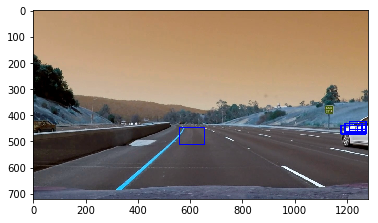

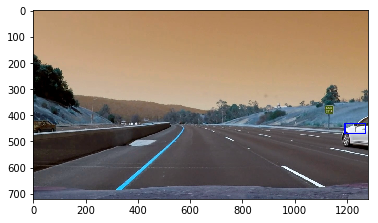

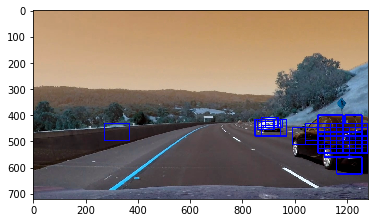

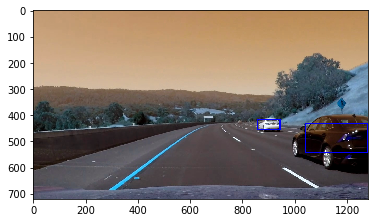

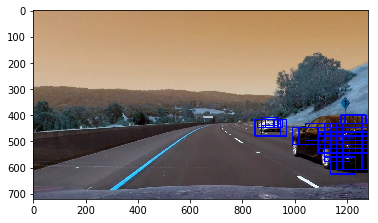

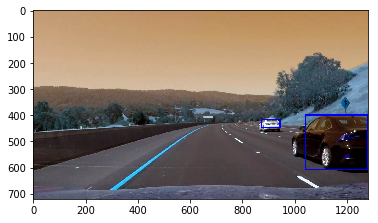

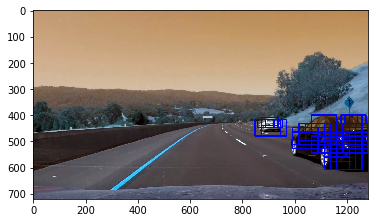

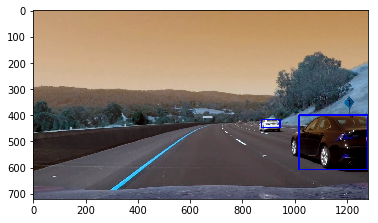

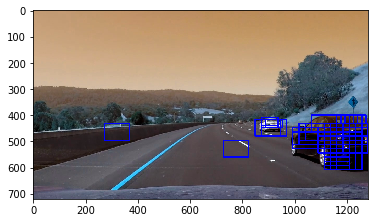

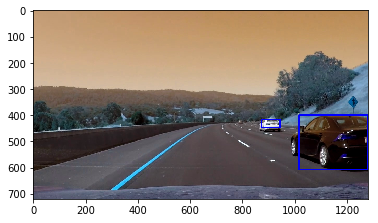

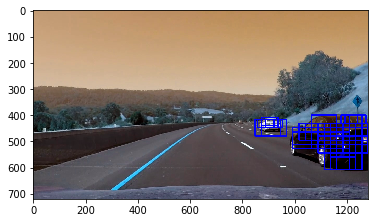

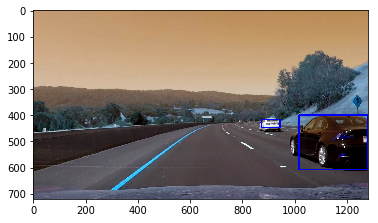

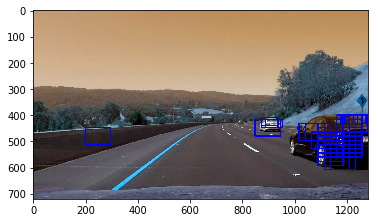

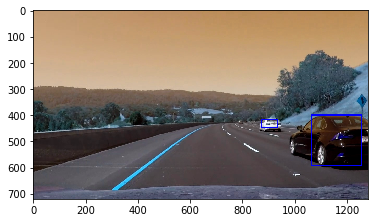

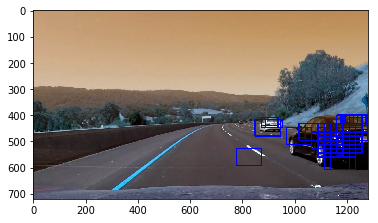

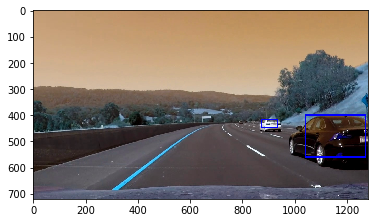

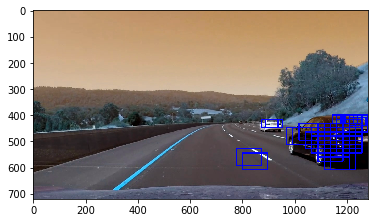

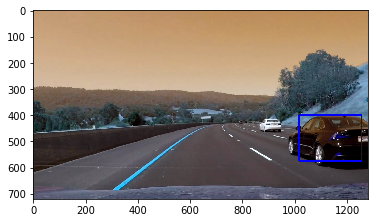

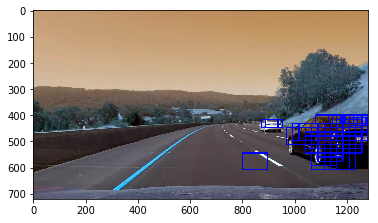

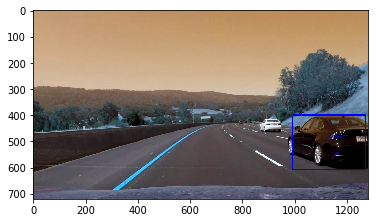

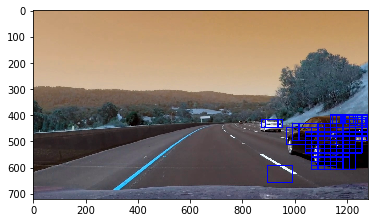

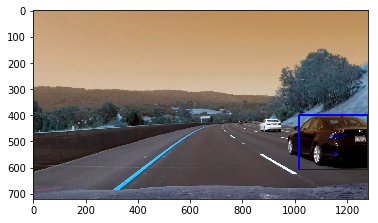

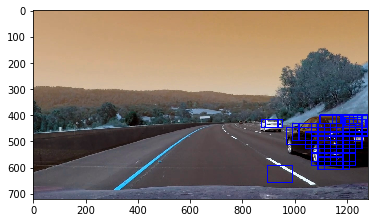

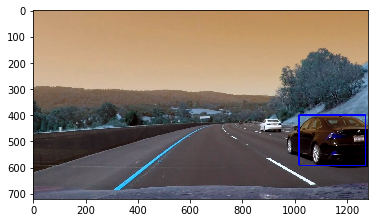

In [158]:
imgs = extract_images(challenge_images_path)["imgs_path"]
for img in imgs:
    test_image = cv2.imread(img)
    car_detected_image, heat_map, car_filtered_img = draw_predicted_cars(test_image, clf, scaler, None)
    plt.imshow(car_detected_image)
    plt.show()
    plt.imshow(car_filtered_img, cmap="hot")
    plt.show()

### Goal 6 - Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

#### Apply vehicle detection algorithm on video stream

In [159]:
def laneDetectionInVideo (sourceFilePath, outputFilePath):
    vehicle_tracker = VehicleTracker()
    originalVideoClip = VideoFileClip(sourceFilePath).subclip(20, 45)
    #originalVideoClip = VideoFileClip(sourceFilePath)
    car_detected = originalVideoClip.fl_image(vehicle_tracker.process_image_frames)
    %time car_detected.write_videofile(outputFilePath, audio=False)

#### Create a heat map around predicted car detections

In [52]:
def create_heat_map(img, bboxes):
    heat_img = np.zeros_like(img[:,:,0])
    for box in bboxes:
        heat_img[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heat_img

#### Apply a thresholded heat map

In [53]:
def apply_threshold_to_heat_map(heat_map, threshold=1):
    thresh_heat_map = np.copy(heat_map)
    thresh_heat_map[heat_map <= threshold] = 0
    return thresh_heat_map

#### Extract bounding boxes around labelled heat map

In [54]:
def extract_bbox_in_heat_map(labeled_heat_img):
    bboxes = []
    for car in range(1, labeled_heat_img[1]+1):
        nonzero = (labeled_heat_img[0] == car).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
    return bboxes

### Main method

In [160]:
def main(video_src, video_dst):
    laneDetectionInVideo(video_src, video_dst)
main("test_video/project_video.mp4", "project-video-with-tracker-20-45.mp4")

OSError: [WinError 6] The handle is invalid

### Goal 7 - Estimate a bounding box for vehicles detected.

#### Utility method to extract average of coordinates of bounding boxes of rectangles

In [86]:
def avg_bboxes(bboxes1, bboxes2):
    avg_boxes = []
    if (len(bboxes1) != len(bboxes2)):
        avg_boxes = bboxes2
    else:
        for i in range(len(bboxes1)):
            bbox1 = bboxes1[i]
            bbox2 = bboxes2[i]
            avg = 0.5*np.add(bbox1, bbox2)
            avg_boxes.append(avg)
    return np.array(avg_boxes, dtype=np.int64)
# image_path = extract_images(test_images_path)["imgs_path"][1]
# image = cv2.imread(image_path)
# bboxes1 = sorted([((800, 400), (959, 511)), ((1056, 400), (1279, 495))], key=lambda x: x[0][0])
# print(bboxes1)
# bboxes2 = sorted([((1056, 400), (1279, 495)),((800, 400), (959, 495))], key=lambda x: x[0][0])
# print(bboxes2)
# print(avg_bboxes(bboxes1, bboxes2))
# avg_bboxes = [((bbox[0][0], bbox[0][1]), (bbox[1][0], bbox[1][1])) for bbox in avg_bboxes(bboxes1, bboxes2)]
# print(avg_bboxes)
#bboxes = [((bbox[0]), (bbox[1]), ((bbox[1][0] - bbox[0][0]) * (bbox[1][1] - bbox[0][1]))) for bbox in bboxes]
# box_img = draw_bounding_boxes(image, bboxes)
# plt.imshow(box_img)
# plt.show()
# centroids = extract_centroids(bboxes)
# print(centroids)
# print(sorted(centroids, key=lambda x: x[0]))
# print(np.mean([centroids, centroids], axis=0, dtype=np.int64))
# print([x for x in tuple(map(tuple, np.mean([centroids, centroids], axis=0, dtype=np.int64)))])
# box_img = draw_bounding_boxes(image, avg_bboxes)
# plt.imshow(box_img)
# plt.show()

#### Create Vehicle tracker class to track positions of vehicles detected subsequent frames

In [101]:
class VehicleTracker():
    def __init__(self):
        self.last_carboxes = None
#         self.last_heatmap = []
        self.last_heatmap = None
        self.retained_heatmap = None
        self.frames_counter = 1
    
    def remove_false_positives(self, current_heat_map):
#         if (self.last_heatmap == None):
#             #retained_feature_heatmap = current_heat_map
#             self.retained_heatmap = current_heat_map
#             self.last_heatmap = current_heat_map
#             avg_heat_map = current_heat_map
# #             plt.imshow(retained_feature_heatmap, cmap="hot")
# #             plt.show()
# #             plt.imshow(current_heat_map, cmap="hot")
# #             plt.show()
#         else:
# #             updates_in_heuristic = np.zeros_like(self.last_heatmap)
# # #             avg_heat_map[(self.last_heatmap != 0) & (current_heat_map != 0)] += 2
# # #             avg_heat_map[(self.last_heatmap == 0) & (current_heat_map != 0)] = self.frames_counter
# # #             retained_feature_heatmap = np.copy(avg_heat_map)
# # #             #Retain newly detected heat map features to averaged heat map in tracker class
# # #             retained_feature_heatmap = apply_threshold_to_heat_map(retained_feature_heatmap, (self.frames_counter - 1))
# # #             #Remove newly detected features from current heat map
# # #             avg_heat_map = apply_threshold_to_heat_map(avg_heat_map, (self.frames_counter))

# #             updates_in_heuristic[(self.last_heatmap != 0) & (current_heat_map != 0)] += 1
# #             updates_in_heuristic[(self.last_heatmap == 0) & (current_heat_map != 0)] = 1
# #             updates_in_heuristic[(self.last_heatmap != 0) & (current_heat_map == 0)] = 1

# # #             plt.imshow(self.last_heatmap, cmap="hot")
# # #             plt.show()
# # #             plt.imshow(current_heat_map, cmap="hot")
# # #             plt.show()
# # #             plt.imshow(avg_heat_map, cmap="hot")
# # #             plt.show()
# #             if (self.frames_counter%10 == 0):
# #     #             new_heatmap_heuristic = np.zeros_like(current_heat_map)
# #     #             new_heatmap_heuristic[(self.last_heatmap != 0) | (current_heat_map != 0)] = 2
# #     #             self.last_heatmap = new_heatmap_heuristic
# #                 self.last_heatmap = apply_threshold_to_heat_map(self.last_heatmap, 1)
# #                 #self.retained_heatmap = apply_threshold_to_heat_map(self.last_heatmap, 5)
# #                 self.retained_heatmap = current_heat_map
# #                 print("Heuristic updated!")
# #             else:
# #                 #self.last_heatmap = retained_feature_heatmap
# #                 self.last_heatmap = updates_in_heuristic
#             avg_heat_map = (self.last_heatmap*0.7) + (current_heat_map*0.3)
#             avg_heat_map = apply_threshold_to_heat_map(avg_heat_map, 1)
#             self.last_heatmap = avg_heat_map
#         if (len(self.last_heatmap) <= 10):
#             self.last_heatmap.append(current_heat_map)
#             avg_heat_map = np.mean([self.last_heatmap[0:]], axis=0)[0]
        if (self.last_heatmap == None):
            self.last_heatmap = current_heat_map
            avg_heat_map = self.last_heatmap
        else:
            avg_heat_map = self.last_heatmap*0.6 + current_heat_map*0.5
            avg_heat_map = apply_threshold_to_heat_map(avg_heat_map, 2)
            #avg_heat_map = self.last_heatmap*0.6 + current_heat_map*0.4
            #self.last_heatmap = apply_threshold_to_heat_map(self.last_heatmap, 2)
            #current_heat_map = apply_threshold_to_heat_map(current_heat_map)
            #resetted_current_heat_map = np.asarray(current_heat_map)
            #resetted_current_heat_map[(self.last_heatmap != 0) & (current_heat_map == 0)] -= 1
            #avg_heat_map = apply_threshold_to_heat_map(avg_heat_map, 1.6)
#             self.last_heatmap = self.last_heatmap[1:]
#             self.last_heatmap.append(current_heat_map)
#             avg_heat_map = np.mean([self.last_heatmap[0:]], axis=0)[0]
            #avg_heat_map = apply_threshold_to_heat_map(avg_heat_map, 2)
#             plt.imshow(self.last_heatmap, cmap="hot")
#             plt.show()
#             plt.imshow(current_heat_map, cmap="hot")
#             plt.show()
#             plt.imshow(resetted_current_heat_map, cmap="hot")
#             plt.show()
#             plt.imshow(avg_heat_map, cmap="hot")
#             plt.show()
            #self.last_heatmap = avg_heat_map
        if (self.frames_counter % 25 == 0):
#             print(np.max(self.last_heatmap))
#             hstack = np.hstack(self.last_heatmap)
#             hist = np.histogram(hstack, bins=np.unique(hstack))
#             plt.plot(hist[0])
#             plt.show()
            self.last_heatmap = None
        return avg_heat_map
    
    def reconstruct_car_boxes(self, current_car_boxes):
        if (self.last_carboxes == None):
            self.last_carboxes = current_car_boxes
#             print("Last box for the first time", self.last_carboxes)
#             print("Current box for the first time", current_car_boxes)
        else:
            current_boxes = sorted(current_car_boxes, key=lambda x: x[0][0])
#             print("Current box", current_boxes)
            last_boxes = sorted(self.last_carboxes, key=lambda x: x[0][0])
#             print("Last box", last_boxes)
            avg_boxes = avg_bboxes(current_boxes, last_boxes)
            avg_boxes = [((bbox[0][0], bbox[0][1]), (bbox[1][0], bbox[1][1])) for bbox in avg_boxes]
#             print("Average boxes", avg_boxes)
            self.last_carboxes = avg_boxes
        return current_car_boxes
    def process_image_frames(self, image):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
#         cv2.imwrite("challenge-images/img-" + str(self.frames_counter) + ".jpg", image)
        predicted, heat_map, filtered = draw_predicted_cars(image, clf, scaler, self, use_vehicle_tracker=True)
#         plt.imshow(image)
#         plt.show()
#         plt.imshow(predicted)
#         plt.show()
#         plt.imshow(heat_map, cmap="hot")
#         plt.show()
#         plt.imshow(filtered)
#         plt.show()
        cv2.imwrite("without-vehicle-tracker/img-" + str(self.frames_counter) + ".jpg", filtered)
        self.frames_counter += 1
        filtered = cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB)
        return filtered